In [1]:
%reload_ext autoreload
%autoreload 2

import sys

import numpy as np
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
sys.path.append("..")
from axionmirror.snr import load_snr_list, best_snrs

## Lightcurve

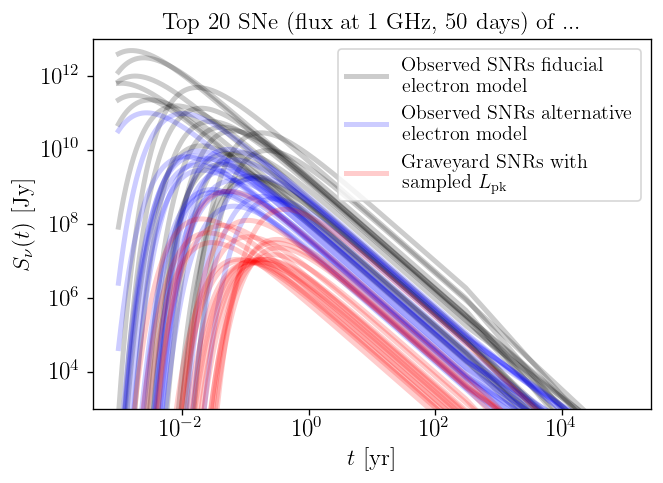

In [11]:
nu_ref = 1000 # [MHz]
t_plot = np.geomspace(0.001, 1e5, 1000)

i_sample = 1

fig, ax = plt.subplots()

ob_list = load_snr_list(f"../outputs/snr/fullinfo_samples/fullinfo_{i_sample}.json") \
        + load_snr_list(f"../outputs/snr/partialinfo_samples/partialinfo_{i_sample}.json")
for i, snr in enumerate(best_snrs(ob_list, 20)):
    label = 'Observed SNRs fiducial\nelectron model'
    ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color='k', alpha=0.2, lw=3, label=(label if i==0 else None))

ob_list_ti1 = load_snr_list(f"../outputs/snr/fullinfo_samples_ti1/fullinfo_{i_sample}.json") \
            + load_snr_list(f"../outputs/snr/partialinfo_samples_ti1/partialinfo_{i_sample}.json")
for i, snr in enumerate(best_snrs(ob_list_ti1, 20)):
    label = 'Observed SNRs alternative\nelectron model'
    ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color='b', alpha=0.2, lw=3, label=(label if i==0 else None))

gy_list = load_snr_list(f"../outputs/snr/graveyard_samples/graveyard_{i_sample}.json")
for i, snr in enumerate(best_snrs(gy_list, 20)):
    label = 'Graveyard SNRs with \nsampled ' + r'$L_\mathrm{pk}$'
    ax.plot(t_plot, snr.Snu_t(nu_ref, t_plot), color='r', alpha=0.2, lw=3, label=(label if i==0 else None))

ax.set(xscale='log', yscale='log')
ax.set(xlabel=r"$t$ [yr]", ylabel=r"$S_{\nu}(t)$ [Jy]", title='Top 20 SNe (flux at 1 GHz, 50 days after SN) of ...')

ax.set(ylim=(1e3, 1e13))
ax.legend();

In [17]:
from axionmirror.graveyard import sample_t_pk

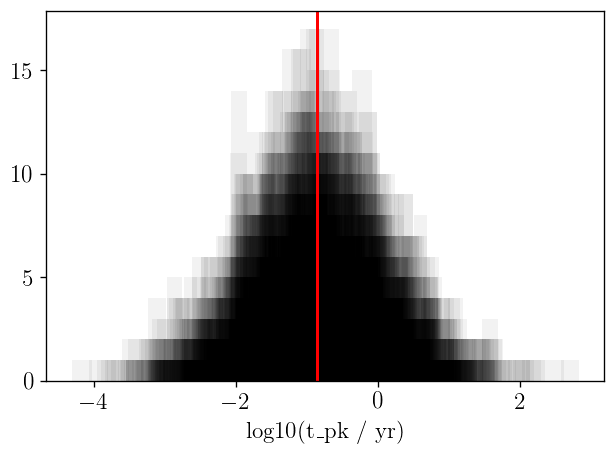

In [17]:
for i in range(100):
    valid_snr_list = load_snr_list(f"../outputs/snr/fullinfo_samples/fullinfo_{i}.json")
    t_pk_sample = [snr.t_pk for snr in valid_snr_list]
    plt.hist(np.log10(t_pk_sample), bins=20, alpha=0.05, color='k')
    plt.xlabel('log10(t_pk / yr)')
    plt.axvline(np.log10(50/365.25), color='r')